In [1]:
from load_model_and_data import loader, known_skew
from bootstrapper import data_iterator, data_iterator_2d
import numpy as np
from os.path import join
import itertools
import pandas as pd
from plotter import pretty_plot

In [2]:
lead_time = 'first_hour'
target = 'tornado'
n_bootstrap=5

cmap = {'tornado' : 'Reds', 
        'severe_hail' : 'Greens',
        'severe_wind' : 'Blues',
       }

(ml_predictions, 
bl_predictions, 
     X, y, 
     init_times, 
     test_dates,
    fti) = loader(lead_time, target)

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from vers

In [3]:
list(X.columns)

['srh_0to1_ens_mean_spatial_mean',
 'srh_0to3_ens_mean_spatial_mean',
 'cape_ml_ens_mean_spatial_mean',
 'cin_ml_ens_mean_spatial_mean',
 'shear_u_0to6_ens_mean_spatial_mean',
 'shear_v_0to6_ens_mean_spatial_mean',
 'shear_u_0to1_ens_mean_spatial_mean',
 'shear_v_0to1_ens_mean_spatial_mean',
 'lcl_ml_ens_mean_spatial_mean',
 'th_e_ml_ens_mean_spatial_mean',
 'u_10_ens_mean_spatial_mean',
 'v_10_ens_mean_spatial_mean',
 'mid_level_lapse_rate_ens_mean_spatial_mean',
 'low_level_lapse_rate_ens_mean_spatial_mean',
 'temperature_850mb_ens_mean_spatial_mean',
 'temperature_700mb_ens_mean_spatial_mean',
 'temperature_500mb_ens_mean_spatial_mean',
 'geopotential_height_850mb_ens_mean_spatial_mean',
 'geopotential_height_700mb_ens_mean_spatial_mean',
 'geopotential_height_500mb_ens_mean_spatial_mean',
 'dewpoint_850mb_ens_mean_spatial_mean',
 'dewpoint_700mb_ens_mean_spatial_mean',
 'dewpoint_500mb_ens_mean_spatial_mean',
 'uh_0to2_time_max_ens_mean_spatial_mean',
 'uh_2to5_time_max_ens_mean_sp

In [6]:
to_be_stratified_x = X['uh_2to5_time_max_ens_mean_of_90th']
to_be_stratified_y = X['wz_0to2_time_max_ens_mean_of_90th']

iterator_x = [0, 50, 225]
iterator_y = [0, 0.001, 0.003]

X['Run Date'] = test_dates
ml_ds, bl_ds = data_iterator_2d(to_be_stratified_x,
                 to_be_stratified_y,
                  ml_predictions, 
                  bl_predictions,
                  X,
                  y, 
                  known_skew[lead_time][target],
                  n_bootstrap,
                  n_bins=2,
                  iterator_x=iterator_x,
                  iterator_y=iterator_y,   
                  forecast_time_indices=None, )

for ds in [ml_ds, bl_ds]:
    ds['xdata'] = iterator_x
    ds['ydata'] = iterator_y

    # Save the results
    #out_path = '/work/mflora/ML_DATA/stratified_results'
    #for ds, mode in zip([ml_ds, bl_ds], ['ml', 'bl']):
    #    ds.to_netcdf(join(out_path, f'{mode}_init_stratify_{lead_time}_{target}.nc'))
    #    ds.close()    

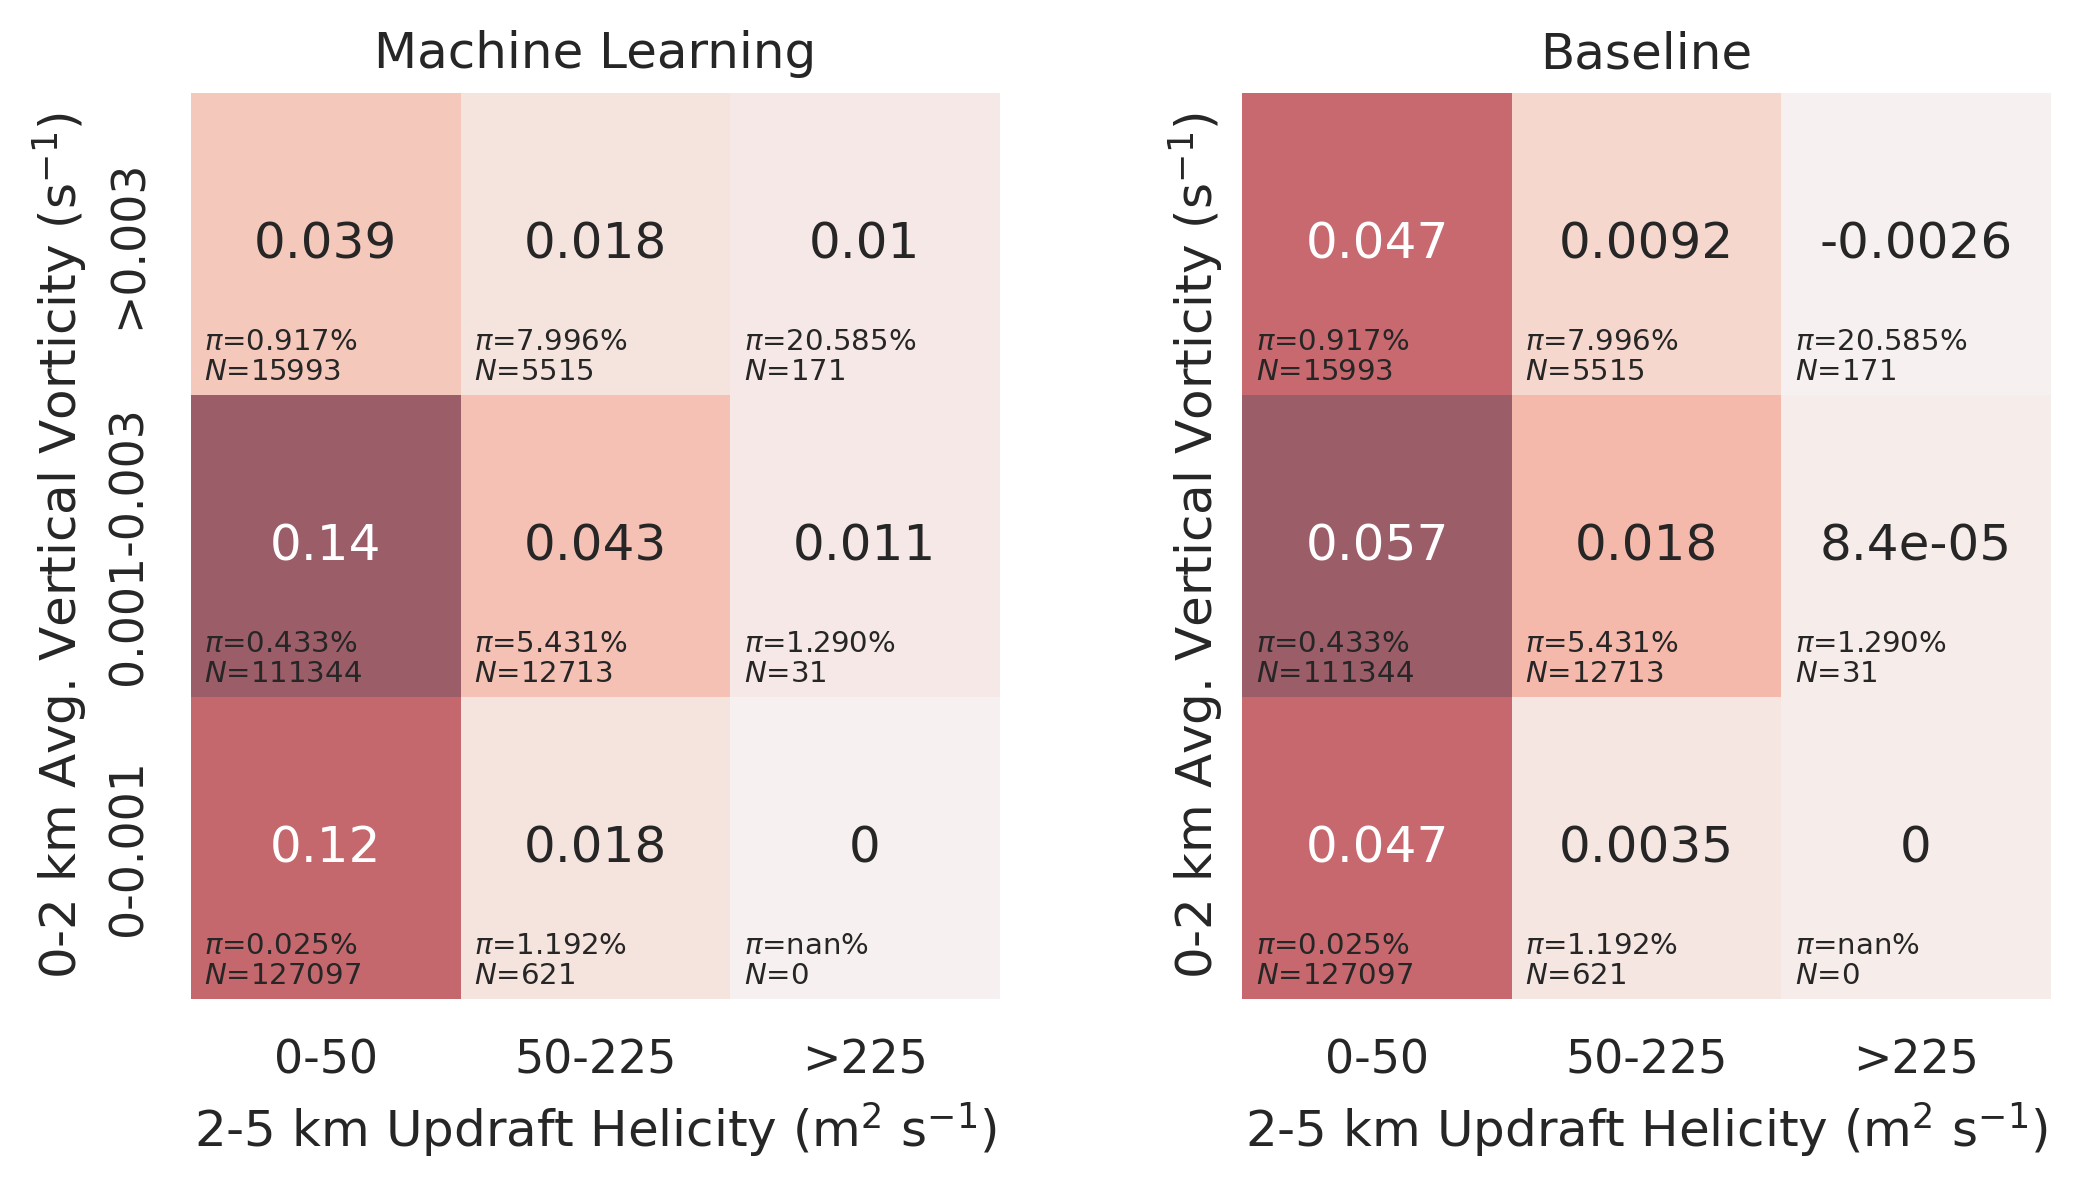

In [7]:
def get_tick_labels(rng):
    return [f'{rng[i]}-{rng[i+1]}' for i in range(len(rng)-1)] + [f'>{rng[-1]}']

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

f, axes = plt.subplots(dpi=300, ncols=2, sharey=True, figsize=(8,4))

titles = ['Machine Learning', 'Baseline']

for ds, ax, title in zip([ml_ds, bl_ds], axes.flat, titles):
    score = np.mean(ds['naupdc'].values, axis=-1)
    
    sns.heatmap(score, ax=ax, 
            annot=True,
            cbar_kws = {'label' : 'NAUPDC'},
                cbar=False,
            cmap = cmap[target],
            alpha=0.6,
            xticklabels=get_tick_labels(iterator_x), 
            yticklabels=get_tick_labels(iterator_y),
           )

    counts = ml_ds['Counts'][:,:,0].values.astype(int)
    skew = np.mean(ml_ds['Skew'].values, axis=-1)*100.

    for i,j in itertools.product(range(3), range(3)):
        ax.annotate(fr"$N$={counts[i,j]}", xy=(i+0.05,j+0.05), fontsize=7)
        ax.annotate(fr"$\pi$={skew[i,j]:.3f}%", xy=(i+0.05,j+0.15), fontsize=7)

    ax.set_xlabel(r'2-5 km Updraft Helicity (m$^{2}$ s$^{-1}$)')
    ax.set_ylabel('0-2 km Avg. Vertical Vorticity (s$^{-1}$)')
    ax.invert_yaxis()
    ax.set_title(title)
    
plt.subplots_adjust(wspace=0.3)